# Corporate account image extraction

In [1]:
import pandas as pd
from PIL import Image
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
import re
import pytesseract

In [2]:
base_path = 'Images/Corporate/'
corporate_imgs = os.listdir(base_path)

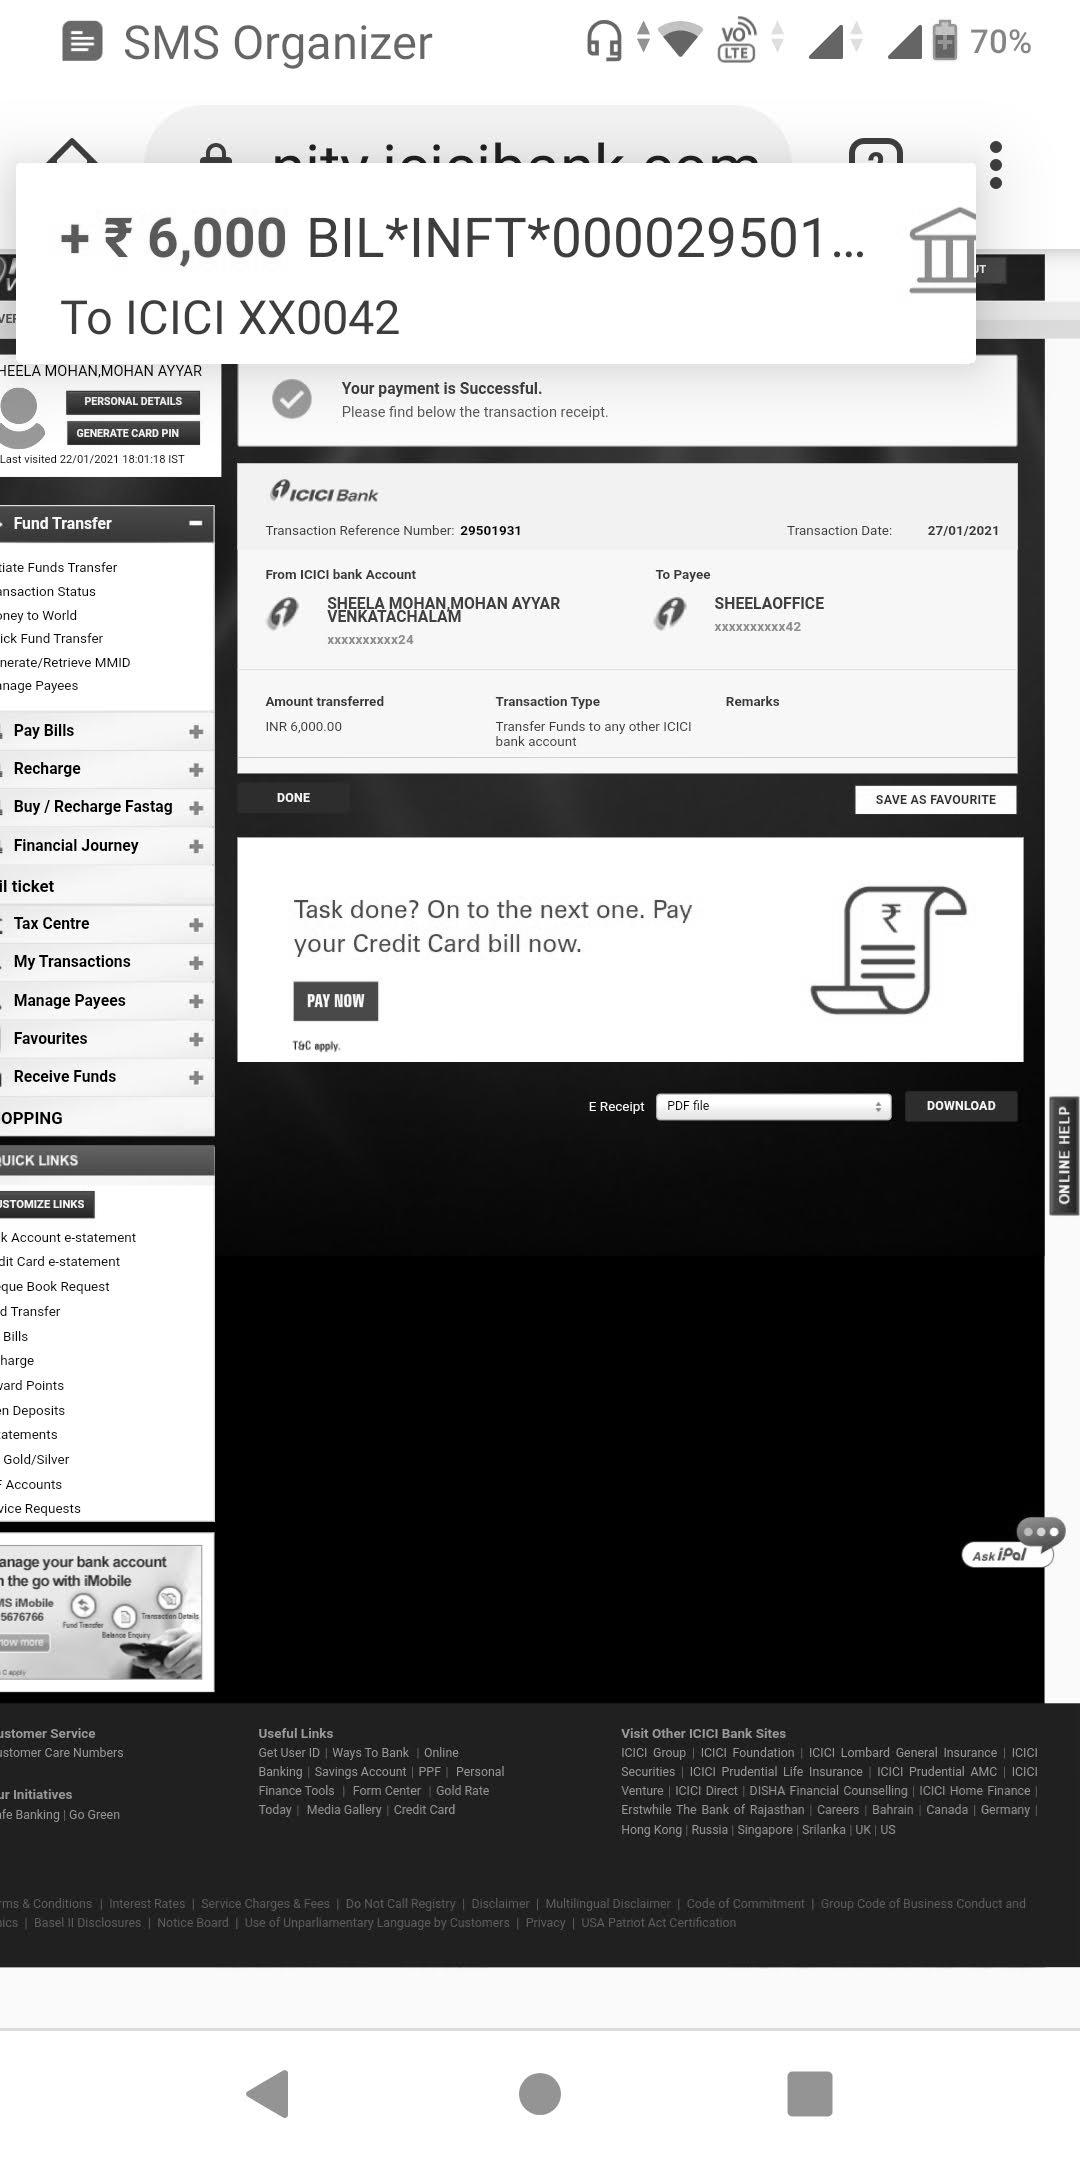

In [12]:
def read_img(base_path,corporate_imgs):
    img = cv2.imread(base_path+corporate_imgs)
    img_bw = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    return img_bw
img_bw = read_img(base_path,corporate_imgs[0])
Image.fromarray(img_bw)

In [25]:
def find_outer_box(img_bw):

    ret, thresh = cv2.threshold(img_bw, 200, 255, cv2.THRESH_OTSU)
    canny = cv2.Canny(thresh,250,255)
    cnts,_ = cv2.findContours(canny,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE)
    cnt_areas = np.array([cv2.contourArea(cnts[i]) for i in range(len(cnts))])
    max_area_region = np.where(cnt_areas == max(cnt_areas))
    #Draw rectangle and crop largest area box in image
    x,y,w,h = cv2.boundingRect(cnts[max_area_region[0][0]])
    ROI = img_bw[y:y+h, x:x+w]
    #ROI = cv2.threshold(ROI,100,255, cv2.THRESH_OTSU)[1]
    extracted_img = Image.fromarray(ROI)
    return x,y,w,h,extracted_img

In [26]:
x,y,w,h,ROI = find_outer_box(img_bw)

In [27]:
def extract_all_text(img):
    extracted_text = pytesseract.image_to_string(img,nice=1)
    return extracted_text

In [28]:
extracted_text = extract_all_text(ROI)
extracted_text

' \n\n \n\nicici Bank\n\nTransaction Reference Number: 29501931 Transaction Date: 27/01/2021\nFrom ICICI bank Account To Payee\n\nSHEELA MOHAN,MOHAN AYYAR SHEELAOFFICE\n\nVENKATACHALAM\n\n399000000042\n\n990000000224\n‘Amount transferred Transaction Type Remarks\nINR 6,000.00 Transfer Funds to any other ICICI\n\nbank account\n\n \n\x0c'

In [29]:
#Function that would dilate image and morph and find contours
def find_contours(img):
    k_dil = cv2.getStructuringElement(cv2.MORPH_RECT, ksize=(15,6))
    dilation1 = cv2.dilate(cv2.bitwise_not(img),kernel = k_dil,iterations =1)
    #plt.imshow(dilation1)
    mask = np.zeros_like(dilation1)
    mask[dilation1>50]=255
    canny = cv2.Canny(mask,0,240)
    # plt.imshow(canny,'gray')
    contours,_ = cv2.findContours(canny,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    return contours


In [30]:
def crop_max_area(img,contours,otsu = True):
    areas_name = np.array([cv2.contourArea(i) for i in contours])
    index_area = np.where(areas_name == max(areas_name))[0][0]
    #print(index_area)
    x,y,w,h = cv2.boundingRect(contours[index_area])
    ROI_ac = img[y-2:y+h+2, x-10:x+w+10]
    ROI_ac = cv2.erode(ROI_ac,(3,3),iterations = 1)
    if otsu==True:
        ROI_ac = cv2.threshold(ROI_ac,0,255,cv2.THRESH_OTSU)[1]
    else:
        pass
    return ROI_ac

In [31]:
def convert_to_text(img):
    import pytesseract
    return pytesseract.image_to_string(img)

# Extracting Everything


In [52]:
def get_txref_date_amt(extracted_text):
    vals = []
    vals.append(re.findall('Transaction Reference Number: \d{0,140}',extracted_text)[0])
    #Extract date
    vals.append(re.findall('\d{2}/\d{2}/\d{4}',extracted_text)[0])
    #Extract Amount
    split_string = extracted_text.split(' ')
    for i in split_string:
        if len(re.findall("INR",i.strip()))!=0:
            vals.append(split_string[split_string.index(i)+1])
        else:
            pass
    return vals
get_txref_date_amt(extracted_text)

['Transaction Reference Number: 29501931', '27/01/2021', '6,000.00']

Payee_Name: SEARS MOHAN MOHAN AYYAR



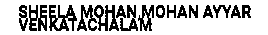

In [33]:
#Payee Name
payee_name_img = img_bw[y+120:y+h-135, x:x+w-400].copy()
def extract_payee_name(img):
    payee_name_contours = find_contours(payee_name_img)
    cropped_payee_name = crop_max_area(payee_name_img,payee_name_contours)
    print('Payee_Name:',convert_to_text(cropped_payee_name))
    Image.fromarray(cropped_payee_name)

In [44]:
#Receiver Name
receiver_name_img = img_bw[y+120:y+h-130, x+400:x+w].copy()
def extract_receiver_name(img):
    receiver_name_img = img
    receiver_name_img[receiver_name_img>120] = 255
    receiver_name_contours = find_contours(receiver_name_img)
    cropped_receiver_name = crop_max_area(receiver_name_img,receiver_name_contours)
    #print('Receiver_Name:',convert_to_text(cropped_receiver_name))
    #Image.fromarray(receiver_name_img)
    return convert_to_text(cropped_receiver_name)

extract_receiver_name(receiver_name_img)

'\x0c'

In [41]:
#Extract payee ac no.
payee_ac_img = img_bw[y+155:y+h-100, x:x+w-350].copy()
def extract_payee_ac_no(img):
    # payee_ac_img[payee_ac_img<200] = 0
    payee_ac_contours = find_contours(payee_ac_img)
    cropped_payee_ac = crop_max_area(payee_ac_img,payee_ac_contours,otsu = False)
    #print('Payee Account Number:',convert_to_text(cropped_payee_ac).strip()[-2:])
    #Image.fromarray(cropped_payee_ac)
    return convert_to_text(cropped_payee_ac).strip()[-2:]

extract_payee_ac_no(payee_ac_img)

'ZS'

In [39]:
#Extract Receive ac no.

receiver_ac_img = img_bw[y+140:y+h-20, x+375:x+w-150]
def extract_receiver_ac_no(img):
    receiver_ac_contours = find_contours(payee_ac_img)
    cropped_receiver_ac = crop_max_area(receiver_ac_img,receiver_ac_contours,otsu = False)
    #print('Payee Account Number:',convert_to_text(cropped_receiver_ac).strip()[-2:])
    #Image.fromarray(cropped_receiver_ac)
    return convert_to_text(cropped_receiver_ac).strip()[-2:]

extract_receiver_ac_no(receiver_ac_img)

'OO'